In [ ]:
%pip install -Uqq fastai duckduckgo_search

## Download images of birds and planes

In [33]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'full plane in sky'


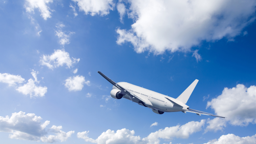

In [34]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images('full plane in sky', max_images=1)[0], 'plane.jpg', show_progress=False)
Image.open('plane.jpg').to_thumb(256,256)

Searching for 'plane in sky far away'


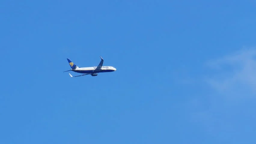

In [36]:
download_url(search_images('plane in sky far away', max_images=1)[0], 'plane.jpg', show_progress=False)
Image.open('plane.jpg').to_thumb(256,256)

Searching for 'a single bird in sky far away'


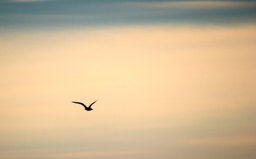

In [44]:
download_url(search_images('a single bird in sky far away', max_images=1)[0], 'bird.jpg', show_progress=False)
Image.open('bird.jpg').to_thumb(256,256)

Searching for 'full plane in sky clear'


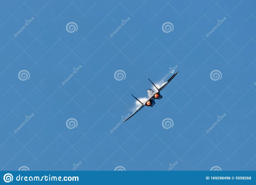

In [49]:
download_url(search_images('full plane in sky clear', max_images=1)[0], 'plane.jpg', show_progress=False)
Image.open('plane.jpg').to_thumb(256,256)

Searching for 'bird in sky clear'


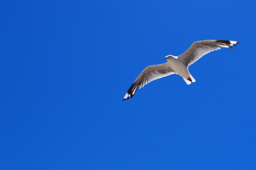

In [25]:
download_url(search_images('bird in sky clear', max_images=1)[0], 'bird.jpg', show_progress=False)
Image.open('bird.jpg').to_thumb(256,256)

In [26]:
searches = 'bird','plane'
path = Path('bird_or_plane')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} in sky photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} in sky far photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in sky clear photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird in sky photo'
Searching for 'bird in sky far photo'
Searching for 'bird in sky clear photo'
Searching for 'plane in sky photo'
Searching for 'plane in sky far photo'
Searching for 'plane in sky clear photo'


In [29]:
fns = get_image_files(path)
fns

(#171) [Path('bird_or_plane/bird/ed2d91ba-2d6f-4f47-bf23-63dd60c5cae8.jpg'),Path('bird_or_plane/bird/e6cae229-6c66-4298-b268-7b695a91b815.jpeg'),Path('bird_or_plane/bird/73553b2b-2a12-4d15-a06e-60d1d90ba931.jpg'),Path('bird_or_plane/bird/a35d2c01-0fbc-4250-a21a-a73cfbaac41c.jpg'),Path('bird_or_plane/bird/52c4d818-3f81-4fad-bd94-3df25fe44f22.jpeg'),Path('bird_or_plane/bird/e1ff123b-e7a5-4a99-b6d5-57cf2a9a1ab8.jpeg'),Path('bird_or_plane/bird/9b4f20d7-81b4-4745-9f1d-1a5f05b20b61.jpeg'),Path('bird_or_plane/bird/e88563fe-bdc4-4287-884c-52b0ef6a477d.jpg'),Path('bird_or_plane/bird/0725866b-e44b-4400-8072-a474974df7bd.jpeg'),Path('bird_or_plane/bird/f6f78afb-e206-4e0f-89fa-b26d8e832e59.png')...]

In [28]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

## Train model

In [30]:
bp = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, # get list of image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # validation
    get_y=parent_label, # know correct label
    item_tfms=[Resize(128)] # 
)

dls = bp.dataloaders(path)

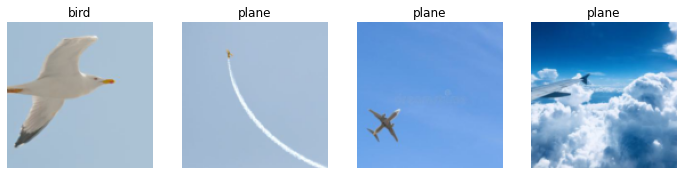

In [31]:
dls.valid.show_batch(max_n=4, nrows=1)

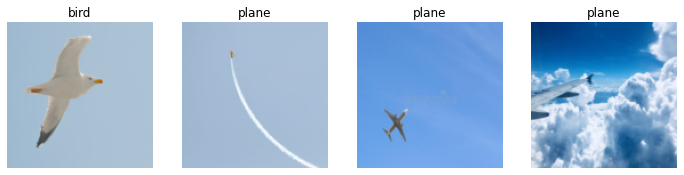

In [32]:
bp = bp.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bp.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

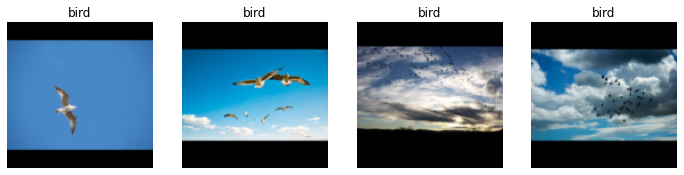

In [13]:
bp = bp.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bp.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

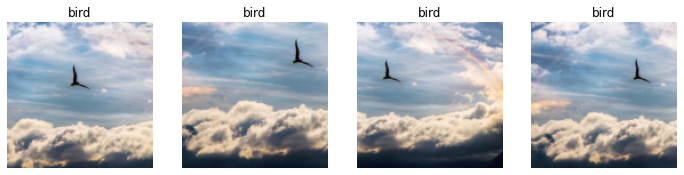

In [14]:
bp = bp.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bp.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

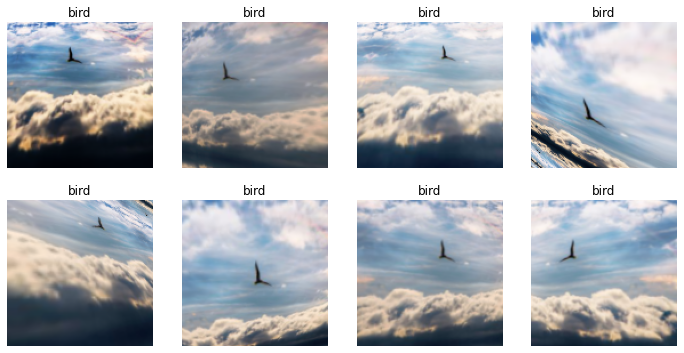

In [15]:
bp = bp.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bp.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
bp = bp.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # transform individual items
    batch_tfms=aug_transforms()) # transform on batch
dls = bp.dataloaders(path)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.114722,0.973318,0.323529,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.686063,0.559977,0.205882,00:38
1,0.564403,0.362688,0.147059,00:38
2,0.490447,0.259923,0.117647,00:38
3,0.424446,0.231921,0.117647,00:38


## Error analysis

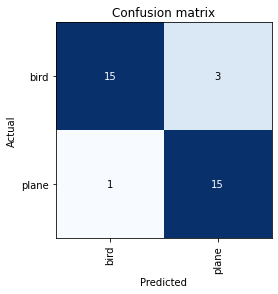

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

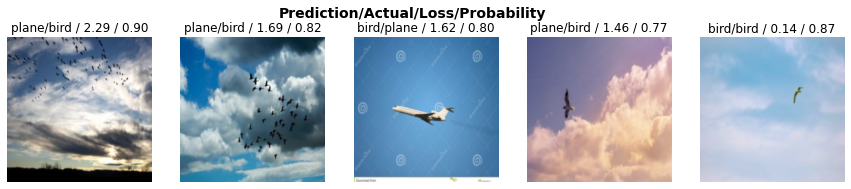

In [19]:
interp.plot_top_losses(5, nrows=1)

In [20]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## test

In [27]:
learn.predict(PILImage.create('plane.jpg'))

('plane', TensorBase(1), TensorBase([0.0062, 0.9938]))

In [30]:
label,_,probs = learn.predict(PILImage.create('plane.jpg'))
print(f"This is a: {label}.")
print(f"Probability: {probs[1]:.4f}")

This is a: plane.
Probability: 0.9938


In [29]:
label,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {label}.")
print(f"Probability: {probs[0]:.4f}")

This is a: bird.
Probability: 1.0000


## export

In [31]:
learn.export('model.pkl')